In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



No density measurements. Creating purely analytical profile.


In [3]:
from transforms import transforms
from Decon import SpectralDecon

In [4]:
site = 'SiteA'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']



### Define data

In [5]:
site = 'SiteA'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [6]:
diffIE = pd.read_csv('/home/thea/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/SiteA_DepthDiffVas.txt','\t')
diffWE = pd.read_csv('/home/thea/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/SiteA_DepthDiff.txt','\t')

depIE = diffIE['Depth']; depIE_LT = depIE[(depIE > dTamb) & (depIE < dLaki)]
difIE = diffIE['sigma_o18']; difIE_LT = difIE[(depIE > dTamb) & (depIE < dLaki)]

depWE = diffWE['Depth']; depWE_LT = depWE[(depWE > dTamb) & (depIE < dLaki)]
difWE = diffWE['sigma_o18']; difWE_LT = difWE[(depWE > dTamb) & (depWE < dLaki)]


0.06527999999999999

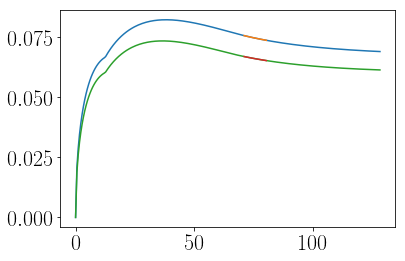

In [7]:
plt.plot(depIE,difIE)
plt.plot(depIE_LT,difIE_LT)

plt.plot(depWE,difWE)
plt.plot(depWE_LT,difWE_LT)
min(difWE_LT)

### Compute diffusion length estimate interval

In [8]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Sigma fit: 7.32
Min sigma analyt: 6.52
Starting sigma: 5.52 [cm]
Final sigma: 6.14 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.019


In [32]:
from DiffusionProfiles_calculations import sampling_sigma
sampleSize_ave = np.mean(np.diff(depth_LT))
print(sampleSize_ave)
sigma_sample = sampling_sigma(sampleSize_ave)
sigma_firn = np.sqrt(diffLen**2 - sigma_sample**2)
sigma_firn

0.03919762845849803


0.060239069029248214

In [10]:
idx32 = np.where(np.asarray(arr_Npeaks) == N_InInt)[0]
idx32Cut = idx32[:-1]

diffLens32_tot = np.asarray(arr_DiffLens)[idx32Cut]
diffLens32_firn = np.sqrt(diffLens32_tot**2 - sigma_sample**2)

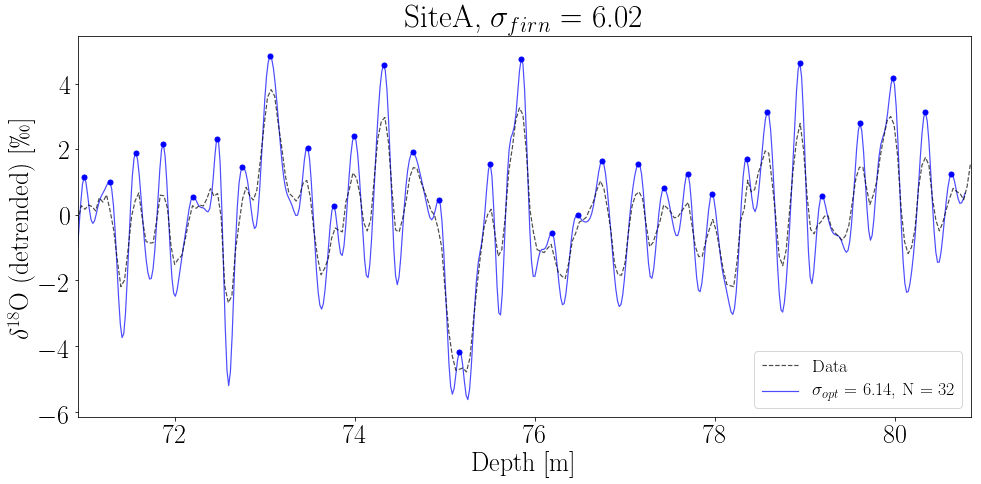

In [11]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site+', $\sigma_{firn}$ = ' + f'{sigma_firn*100:.2f}',xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='b',zorder=1, s=25)


#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')


### Determine temperature estimate interval (analytical solution) using modern day accumulation rate

In [12]:
accum = accum0 #*(804.3/917.0)

sigmaSolver_inst = sigma_Solver()

print(f'Accumulation estimate (W.E.): {accum:.3f}')
print(f'Accumulation estimate (I.E.): {accumIE:.3f}')

print(f'Modern temperature estimate: {Temp0}\n')

diffLens32 = diffLens32_firn
T_intEst = np.zeros(len(diffLens32))

for i in range(len(diffLens32)):
    T_est = sigmaSolver_inst.solveTemp(sigma_data = diffLens32[i], accum = accum)# *(804.3/917.)
    T_intEst[i] = T_est
    if i%10 == 0:
        print(f'Computed temperature estimate: {T_est[0] - 273.15:.2f}')

Accumulation estimate (W.E.): 0.282
Accumulation estimate (I.E.): 0.307
Modern temperature estimate: -29.41

Computed temperature estimate: -39.30
Computed temperature estimate: -38.86
Computed temperature estimate: -38.38
Computed temperature estimate: -37.91
Computed temperature estimate: -37.44
Computed temperature estimate: -36.98
Computed temperature estimate: -36.53


In [13]:
from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [14]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInt = [32, 33, 33, 32, 32, 32]

T_est = []
diffLens_est = []
Tf_est = []
diffLens_est_f = []
for site, N in zip(sites,N_InInt):
    print(site+'\n')
    T, dL, Tf, dLf = TempEst_analytical(site, N)
    T_est.append(T)
    diffLens_est.append(dL)
    Tf_est.append(Tf)
    diffLens_est_f.append(dLf)


SiteA

Sigma fit: 7.32
Min sigma analyt: 6.52
Starting sigma: 5.52 [cm]
Final sigma: 6.14 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.019
0.03919762845849803
SiteB

Sigma fit: 7.55
Min sigma analyt: 6.43
Starting sigma: 5.43 [cm]
Final sigma: 5.85 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019
0.03885401459854004
SiteD

Sigma fit: 7.83
Min sigma analyt: 6.25
Starting sigma: 5.25 [cm]
Final sigma: 4.56 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.019
0.03774461538461542
SiteE

Sigma fit: 7.76
Min sigma analyt: 7.50
Starting sigma: 6.50 [cm]
Final sigma: 5.95 [cm]
Final # of peaks: 32
Delta: 0.041
Delta new: 0.021
0.042455357142857135
SiteG

Sigma fit: 7.94
Min sigma analyt: 7.66
Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.668 cm
Final sigma: 8.46 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.020
0.04102777777777775
Crete

No ECM file found, setting empty df instead
Sigma fit: 7.47
Min sigma analyt: 7.28
Starting sigma: 6.28 [cm]
Final sigma: 6.02 

SiteA T0 = -29.41
SiteB T0 = -29.77
SiteD T0 = -28.3
SiteE T0 = -30.37
SiteG T0 = -30.1
Crete T0 = -30.4


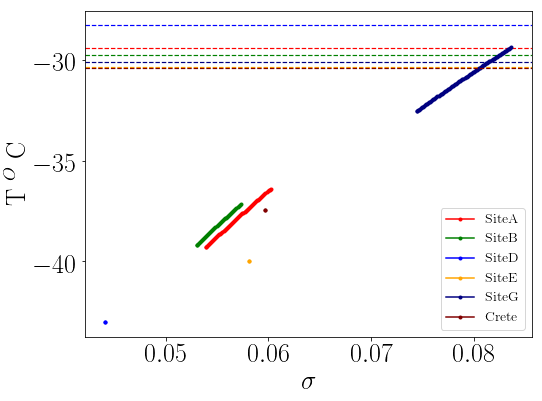

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

Ts = [-29.41, -29.77, -28.30, -30.37, -30.10, -30.40]
colors = ['red','green','blue','orange','navy','maroon']
for i in range(len(Tf_est)):
    #ax.axhline(y=Ts[i])
    print(f'{sites[i]} T0 = {Ts[i]}')
    ax.axhline(y=Ts[i],color=colors[i], lw=1.2, ls='--')
    ax.plot(diffLens_est_f[i], Tf_est[i]-273.15, label=sites[i],marker='.', color=colors[i])
ax.set(xlabel='$\sigma$', ylabel='T $^O$ C')    
ax.legend(fontsize=14)

### Determine temperature estimate interval (analytical solution) using varying accumulation rate

In [24]:
sigmaFirn_max = np.zeros(len(diffLens_est_f))
dzs = [0.03919762845849803, 0.03885401459854004, 0.03774461538461542, 0.042455357142857135, 0.04102777777777775,0.026775401069518666]

for i in range(len(diffLens_est_f)):
    sigma_max = max(diffLens_est_f[i])
    sigma_sample = sampling_sigma(dzs[i])
    
    sigmaFirn_max[i] = np.sqrt(sigma_max**2 - sigma_sample**2)

In [25]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInt = [32, 33, 33, 32, 32, 32]
T0s = [-29.41, -29.77, -28.30, -30.37, -30.10, -30.40]
Accum0s = np.asarray([0.307, 0.327, 0.365, 0.225, 0.251,0.28])*(917/1000)
diffLen_maxs = sigmaFirn_max#[0.0614, 0.0585, 0.0456, 0.0595, 0.0846, 0.0602]
#diffLen_teos = [0.0652, 0.0643, 0.0625,0.0750,0.0766,0.0728]

j = 0
site = sites[j]
N = N_InInt[j]
T0 = T0s[j]
Accum0 = Accum0s[j]
diffLen_max = diffLen_maxs[j]

accum_arr = np.arange(0.05,1,0.01)


In [26]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = np.asarray(data_d18O_LT['depth'])
d18O_LT = np.asarray(data_d18O_LT['d18O'])


In [27]:
diff = data_diff['sigma_o18']
dep = data_diff['Depth']

diff_LT = data_diff_LT['sigma_o18']
dep_LT = data_diff_LT['Depth']

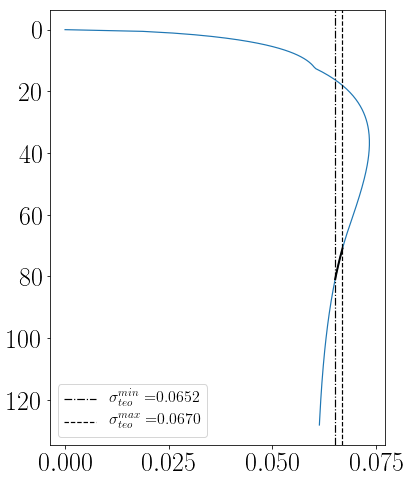

In [28]:
fig,ax = plt.subplots(figsize = (6,8))
ax.invert_yaxis()
plt.plot(np.asarray(diff),np.asarray(dep), lw=1.2)
plt.plot(np.asarray(diff_LT),np.asarray(dep_LT), color='k', lw=2)
plt.axvline(min(diff_LT),ls='-.',color='k',lw=1.2,label='$\sigma_{teo}^{min} = $'+f'{min(diff_LT):.4f}')
plt.axvline(max(diff_LT),ls='--',color='k',lw=1.2,label='$\sigma_{teo}^{max} = $'+f'{max(diff_LT):.4f}')

ax.legend(fontsize=16);

diffLen_teoMin = min(diff_LT)
diffLen_teoMax = max(diff_LT)


In [29]:
from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [30]:
T_est = np.zeros(len(accum_arr))
T_teoMin_est = np.zeros(len(accum_arr))
T_teoMax_est = np.zeros(len(accum_arr))

i = 0
for accum in accum_arr:
    T = TempEst_analytical_arr(np.array([diffLen_max]),accum)
    T_teoMin = TempEst_analytical_arr(np.array([diffLen_teoMin]),accum)
    T_teoMax = TempEst_analytical_arr(np.array([diffLen_teoMax]),accum)
    T_est[i] = T[-1]
    T_teoMin_est[i] = T_teoMin[-1]
    T_teoMax_est[i] = T_teoMax[-1]
    i += 1

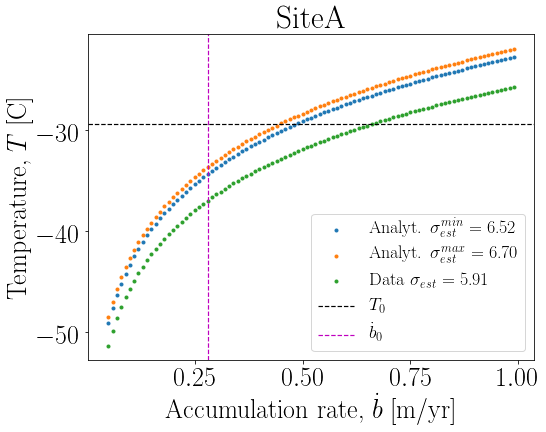

In [31]:
fig, ax = plt.subplots(figsize=(8,6))


ax.plot(accum_arr,T_teoMin_est-273.15,'.',label='Analyt. $\sigma_{est}^{min}$' + f' = {diffLen_teoMin*100:.2F}')
ax.plot(accum_arr,T_teoMax_est-273.15,'.',label='Analyt. $\sigma_{est}^{max}$' + f' = {diffLen_teoMax*100:.2F}')
ax.plot(accum_arr,T_est-273.15,'.',label='Data $\sigma_{est}$' + f' = {diffLen_max*100:.2F}')
ax.axhline(y=T0,ls='--',color='k', lw=1.2, label='$T_0$')
ax.axvline(x=Accum0,ls='--',color='m', lw=1.2, label='$\dot{b}_0$')
ax.set(xlabel='Accumulation rate, $\dot{b}$ [m/yr]', ylabel='Temperature, $T$ [C]', title=site)
ax.legend(fontsize=18)